In [7]:
#pip install statsmodels
#!pip install openpyxl
#!pip install causal-learn
#!pip install --upgrade numpy --user
#!pip show numpy
#!pip install seaborn
#!conda run pip install seaborn==0.13.2
# !module load 2023
# !module load Python/3.11.3-GCCcore-12.3.0
!python3.11 -m venv myenv
!source myenv/bin/activate
# !pip install numpy==1.25.2 scipy==1.15.1
!pip install --upgrade scipy==1.15.1 --user
# !pip install --upgrade numba --user
#!pip install  "numpy>=2.0,<2.3" --user
!pip show scipy

  Using cached scipy-1.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (40.6 MB)
Name: scipy
Version: 1.11.1
Summary: Fundamental algorithms for scientific computing in Python
Home-page: https://scipy.org/
Author: 
Author-email: 
License: Copyright (c) 2001-2002 Enthought, Inc. 2003-2023, SciPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions
are met:

1. Redistributions of source code must retain the above copyright
   notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above
   copyright notice, this list of conditions and the following
   disclaimer in the documentation and/or other materials provided
   with the distribution.

3. Neither the name of the copyright holder nor the names of

In [4]:
!module purge
!module load 2023
!module load Python/3.11.3-GCCcore-12.3.0

# !python -m venv ~/venvs/pklfix
# !source ~/venvs/pklfix/bin/activate
# !python -m pip install --upgrade pip
# !pip install "numpy==2.1.3"   # has numpy._core, still <2.3
# !python - <<'PY'
# import pickle, numpy as np
print("NumPy:", np.__version__)

NumPy: 1.25.1


In [8]:
import math
import multiprocessing as mp
import time
import datetime
import numpy as np
import scipy
from scipy.optimize import minimize
#from scipy.stats import zscore
from scipy.optimize import differential_evolution
from simulation_G import simulation
from simulation_A import simulation as simulation_A
from simulation_C import simulation as simulation_C
from simulation_E import simulation as simulation_E
from matplotlib.colors import ListedColormap, BoundaryNorm

import pickle
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import cm
import itertools
import statsmodels.api as sm
import matplotlib.patches as mpatches
import os

from scipy.stats import ranksums
from itertools import combinations

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

import networkx as nx
from scipy.stats import rankdata
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster
import seaborn as sns
import sys

import warnings


warnings.filterwarnings("ignore", category=FutureWarning)
#from causallearn.graph.GraphUtils import GraphUtils
%matplotlib inline
os.environ["NUMEXPR_MAX_THREADS"] = "128"
print(scipy.__version__)

1.11.1


In [9]:
np.random.seed(42)
countries=['Israel', 'Mexico', 'Greece', 'Canada', 'Ukraine', 'Australia', 'Turkey', 'Bosnia and Herzegovina', 
                 'Portugal', 'Indonesia', 'Algeria', 'Poland', 'Ghana', 'Russia', 'Nigeria', 'Peru', 'India','Austria',
                'Thailand', 'Spain', 'Italy', 'Sweden', 'Ecuador', 'Colombia', 'Kenya',  'Kazakhstan', 'Mozambique',
                'Sri Lanka', 'Argentina', 'United Kingdom', 'Chile', 'Finland', 'United Arab Emirates', 'Malaysia', 'Germany', 
                'Vietnam', 'Ireland', 'Qatar', 'Japan', 'Brazil', 'Singapore', 'Slovakia', 'Saudi Arabia', 'South Korea','Czech Republic','Hungary','Netherlands']
n_countries = len(countries)  # Number of countries in the dataset
print(n_countries)

47


In [10]:
cal_date_range = pd.date_range(start='01/25/2020', end='01/25/2021', freq='D')
val_date_range = pd.date_range(start='01/26/2021', end='07/26/2021', freq='D')
date_range = pd.date_range(start='01/25/2020', end='07/26/2021', freq='D')

In [11]:
#input signals
file_name='Data/new_deaths_mil.pickle'
new_death_df =pd.read_pickle(file_name)

file_name='Data/new_cases_mil.pickle'
new_case_df =pd.read_pickle(file_name)

file_name='Data/policy.pickle'
policy_df=pd.read_pickle(file_name)

#For calibration over entire time period
file_name='Data/mask_complete.pickle'
mask_df=pd.read_pickle(file_name)


# Split into calibration and validation periods for temporal validation
file_name='Data/mask_validation.pickle'
mask_df_val=pd.read_pickle(file_name)


file_name='Data/mask_calibration.pickle'
mask_df_cal=pd.read_pickle(file_name)
    


In [12]:
# Predict mask-wearing behavior with current parameters
def country_predicted(country, mu,beta,country_params1,model):
    
    disease_incidence = np.array(new_death_df[new_death_df['country'] == country]['Deaths per mil'])
    policy_mandates = np.array(policy_df[policy_df['Country'] == country]['H6M_Facial Coverings'])
    
    if model=='A':
        mask_wearing_predicted = simulation_A(disease_incidence,policy_mandates, country_params1,mu,beta)
    elif model=='C':
        mask_wearing_predicted = simulation_C(disease_incidence,policy_mandates, country_params1,mu,beta)
    elif model=='E':
        mask_wearing_predicted = simulation_E(disease_incidence,policy_mandates, country_params1,mu,beta)
    else:
        mask_wearing_predicted = simulation(disease_incidence,policy_mandates, country_params1,mu,beta)
        
    return mask_wearing_predicted

# Function to calculate error for one country
def country_error(country_params1,country_id,mu,beta, period,model):
    
    
    country=countries[country_id]
    
    if period=='cal':
        mask_wearing_observed = mask_df_cal[mask_df_cal['country'] == country]['pct']
        date_observed=mask_df_cal[mask_df_cal['country'] == country]['days_from_reference']
    elif period=='val' :
        mask_wearing_observed = mask_df_val[mask_df_val['country'] == country]['pct']
        date_observed=mask_df_val[mask_df_val['country'] == country]['days_from_reference']
    else: 
        mask_wearing_observed = mask_df[mask_df['country'] == country]['pct']
        date_observed=mask_df[mask_df['country'] == country]['days_from_reference']
    
    
    # Predict mask-wearing behavior with current parameters
    mask_wearing_predicted = country_predicted(country, mu,beta,country_params1,model)
    
    # Calculate the error (Mean Squared Error)
    error =np.sqrt( np.mean((mask_wearing_observed - mask_wearing_predicted[date_observed]) ** 2))
    
         
    return error

def country_var(country_params1,country_id,mu,beta, period,model):
    
    
    country=countries[country_id]
    
    if period=='cal':
        mask_wearing_observed = mask_df_cal[mask_df_cal['country'] == country]['pct']
        date_observed=mask_df_cal[mask_df_cal['country'] == country]['days_from_reference']
    elif period=='val' :
        mask_wearing_observed = mask_df_val[mask_df_val['country'] == country]['pct']
        date_observed=mask_df_val[mask_df_val['country'] == country]['days_from_reference']
    else: 
        mask_wearing_observed = mask_df[mask_df['country'] == country]['pct']
        date_observed=mask_df[mask_df['country'] == country]['days_from_reference']
    
    
    # Predict mask-wearing behavior with current parameters
    mask_wearing_predicted = country_predicted(country, mu,beta,country_params1,model)
    
    # Calculate the error (Mean Squared Error)
    #error =np.sqrt( np.mean((mask_wearing_observed - mask_wearing_predicted[date_observed]) ** 2))
    
         
    return np.std(mask_wearing_observed),np.std(mask_wearing_predicted[date_observed])

def country_error_boot(country_params,country_id,mu,beta, period,y_obs,model):
    
    
    country=countries[country_id]
    
    if period=='cal':
        date_observed=mask_df_cal[mask_df_cal['country'] == country]['days_from_reference']
    elif period=='val' :
        date_observed=mask_df_val[mask_df_val['country'] == country]['days_from_reference']
    else: 
        date_observed=mask_df[mask_df['country'] == country]['days_from_reference']
    
    # Predict mask-wearing behavior with current parameters
    mask_wearing_predicted = country_predicted(country, mu,beta,country_params,model)
    
    # Calculate the error (Mean Squared Error)
    error =np.sqrt( np.mean((y_obs - mask_wearing_predicted[date_observed]) ** 2))
             
    return error
def country_residual(country_params,country_id,mu,beta, period,model):
    
    country=countries[country_id]
    
    if period=='cal':
        mask_wearing_observed = mask_df_cal[mask_df_cal['country'] == country]['pct']
        date_observed=mask_df_cal[mask_df_cal['country'] == country]['days_from_reference']
    elif period=='val' :
        mask_wearing_observed = mask_df_val[mask_df_val['country'] == country]['pct']
        date_observed=mask_df_val[mask_df_val['country'] == country]['days_from_reference']
    else: 
        mask_wearing_observed = mask_df[mask_df['country'] == country]['pct']
        date_observed=mask_df[mask_df['country'] == country]['days_from_reference']
    
   
    # Predict mask-wearing behavior with current parameters
    mask_wearing_predicted = country_predicted(country, mu,beta,country_params,model)
    
    # Calculate residuals
    residual = mask_wearing_observed - mask_wearing_predicted[date_observed]
    
    y_pred=mask_wearing_predicted[date_observed]
    
    return residual,y_pred 

# Helper: Block bootstrap function
def block_bootstrap_residuals(e, block_len):
    """Return a bootstrap sample of residuals with length = len(e)."""
    T = len(e)
    #if block_len==1:
    #    boot_series=np.random.choice
    
    # Build overlapping blocks
    blocks = []
    for start in range(T - block_len + 1):
        blocks.append(e[start : start + block_len])
    blocks = np.array(blocks, dtype=object)  # shape ~ (T-L+1, block_len)

    # Number of blocks needed
    num_blocks_needed = int(np.ceil(T / block_len))
    
    # Randomly pick blocks, concatenate
    boot_series = []
    for _ in range(num_blocks_needed):
        idx = np.random.randint(0, len(blocks))
        boot_series.append(blocks[idx])
    boot_series = np.concatenate(boot_series, axis=0)
    
    # Truncate to length T
    return boot_series[:T]

        

# Parallelized optimization of country-specific parameters
def optimize_country_params(mu,beta, country_id,period,model,param_bounds):
    
    
    result = differential_evolution(country_error, bounds=param_bounds, args=(country_id,mu,beta,period,model,),popsize=25,strategy='best1bin',seed=42,tol=1e-3)
    
    
    return result.x

def optimize_country_params_boot(mu,beta, country_id,y_obs,initial_country_params,period,model,param_bounds):
    
    result = minimize(country_error_boot, initial_country_params, args=(country_id, mu,beta,period,y_obs,model,), method='L-BFGS-B',bounds=param_bounds)
    return result.x



In [13]:
def combine_country_dataframes(dataframes, country_column="Country"):
    """
    Combines a list of dataframes with country-level data, ensuring that missing variables for some countries
    are represented as NaN.

    Parameters:
    - dataframes (list of pd.DataFrame): List of dataframes to combine.
    - country_column (str): The name of the column that identifies countries. Defaults to "country".

    Returns:
    - pd.DataFrame: Combined dataframe with all variables and countries.
    """
    # Start with an empty dataframe with the country column as a base
    combined_df = pd.DataFrame()
    
    for df in dataframes:
        # Ensure the country column exists
        if country_column not in df.columns:
            raise ValueError(f"Each dataframe must contain a '{country_column}' column.")
        
        # Merge the current dataframe with the combined one on the country column
        if combined_df.empty:
            combined_df = df.copy()
        else:
            combined_df = pd.merge(combined_df, df, on=country_column, how="outer")
    
    return combined_df

# Tuning the rate of decision review (mu) and the rationality of decision-making (beta)

In [78]:
n_countries = len(countries)  # Number of countries in the dataset
period='complete'
models=['A','B','C','D','E','F','G']
num_of_parmeters_list=[1,2,1,2,2,3] # Number of parameters to optimize for each country
model='G'  # Choose the model to use for simulation
start_time = datetime.datetime.now()
p = mp.Pool(processes=128)
# Print the start time
print("Simulation started at:", start_time.strftime("%H:%M"))
st = time.time()

param_bounds=[(1e-5,20),(1e-5, 20),(1e-5,20)]
num_of_parmeters=len(param_bounds)  # Number of parameters to optimize for each country

mu_list=np.linspace(0.4,1.0,15)
beta_list=np.linspace(0.2,0.55,15)
#print(f"Common parameters: {mu}")
n_countries = len(countries)  # Number of countries in the dataset

input_list= np.array([(mu,beta,ii,period,model,param_bounds) for mu,beta,ii in itertools.product(mu_list,beta_list,range(n_countries))], dtype=object)


country_params_list=p.starmap(optimize_country_params,input_list)

et = time.time()
elapsed_time = et - st
print('Calibration time:', elapsed_time, 'seconds')
p.close()
p.join()


Simulation started at: 15:46
Calibration time: 4643.917299985886 seconds


In [79]:
country_params_list=np.array(country_params_list)

country_params_list.shape=(len(mu_list),len(beta_list),n_countries,3)
        
error_list = np.zeros((len(mu_list),len(beta_list),n_countries))

for i,mu in enumerate(mu_list):
    for ii,beta in enumerate(beta_list):
    #cal_error=0
        for iii in range(len(countries)):
            country_specific_param = country_params_list[i,ii,iii]
            error_list[i,ii,iii] = country_error(country_specific_param,iii, mu, beta,'all',model)
            
# with open('country_parameters_mu_tuning_rand.pickle','wb') as f:
#     pickle.dump((country_params_list,error_list,mu_list,beta_list),f)

# np.savez("country_parameters_mu_tuning_G.npz",  country_params_list= country_params_list, error_list=error_list, mu_list=mu_list, beta_list=beta_list)
            


In [15]:
# file_name='country_parameters_mu_tuning_rand.pickle'
#file_name='country_parameters_mu_tuning_G.pkl'

# data = np.load("country_parameters_mu_tuning_G.npz")
# country_params_list = data["country_params_list"]
# error_list = data["error_list"]     
# mu_list = data["mu_list"]
# beta_list = data["beta_list"]



error_list1=np.zeros((len(mu_list),len(beta_list)))

for i in range(len(mu_list)):
    for ii in range(len(beta_list)):
        for iii in range(n_countries):
            error_list1[i,ii]+=error_list[i,ii,iii]**2

error_list1=np.sqrt(error_list1/n_countries)

Minimum error: 0.0639
mu: 0.7578947368421053
beta: 0.39473684210526316


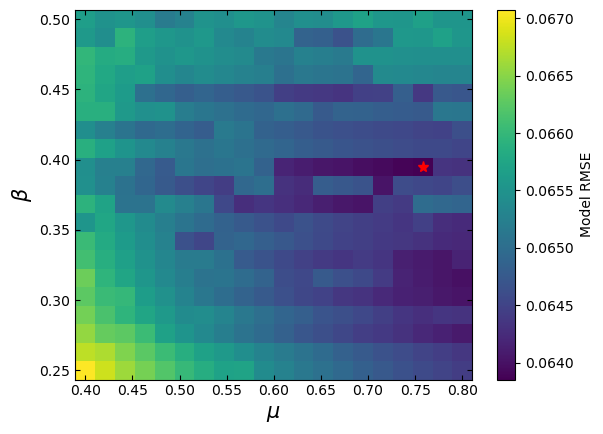

In [16]:



#error_list1=np.mean(error_list,axis=2)
#error_list1=np.round(error_list1,4)
#print(error_list1)
fig, ax = plt.subplots()
cmap = plt.cm.viridis

#norm = BoundaryNorm(boundaries, cmap.N, clip=True)
X, Y = np.meshgrid(mu_list[:], beta_list[:])

c=ax.pcolormesh(X, Y, error_list1[:,:].T, cmap=cmap,shading='auto')

min_idx = np.unravel_index(np.argmin(error_list1[:,:]), error_list1[:,:].shape)

# Get corresponding values
mu_val = mu_list[ min_idx[0]]   # offset by 3 because of slicing
beta_val = beta_list[min_idx[1]]
min_error = error_list1[ min_idx[0], min_idx[1]]
#param_list_cases= country_params_list[min_idx[0],min_idx[1],:]
ax.plot(mu_val, beta_val, marker='*', color='red', markersize=8, label='Min Error')
print(f"Minimum error: {min_error:.4f}")
print(f"mu: {mu_val}")
print(f"beta: {beta_val}")     
        


ax.set_ylabel(r'$\beta$',fontsize=15)
ax.set_xlabel('$\mu$ ',fontsize=15)
#plt.yticks([4,3,2,1],fontsize=14)
#plt.xticks(fontsize=14)
#plt.yscale("log")
plt.colorbar(c,ax=ax,label='Model RMSE' )

ax.tick_params(bottom=True, top=True, left=True, right=True,direction="in")
#print(param_list_cases)
#fig.savefig("beta_mu_heatmap.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)

In [17]:
er_list_1= error_list[min_idx]
#print(er_list)
t=np.sum([x**2 for x in er_list_1])
t=t/47
t=np.sqrt(t)
print(t)
print(np.median(er_list_1))
print(np.mean(er_list_1))

0.06385281898881888
0.0503332998456217
0.056330009314049294


In [22]:
mu=0.758
beta=0.395

In [19]:
mu = mu_list[ min_idx[0]]   
beta = beta_list[min_idx[1]]
cal_error=error_list[min_idx]
country_params=country_params_list[min_idx]
df = pd.DataFrame(country_params, columns=['Risk_weight','Norm_weight', 'Policy_weight'])


# Add a column for countries (optional)
df['Country'] = [country for country in countries]
df['Error'] =cal_error 



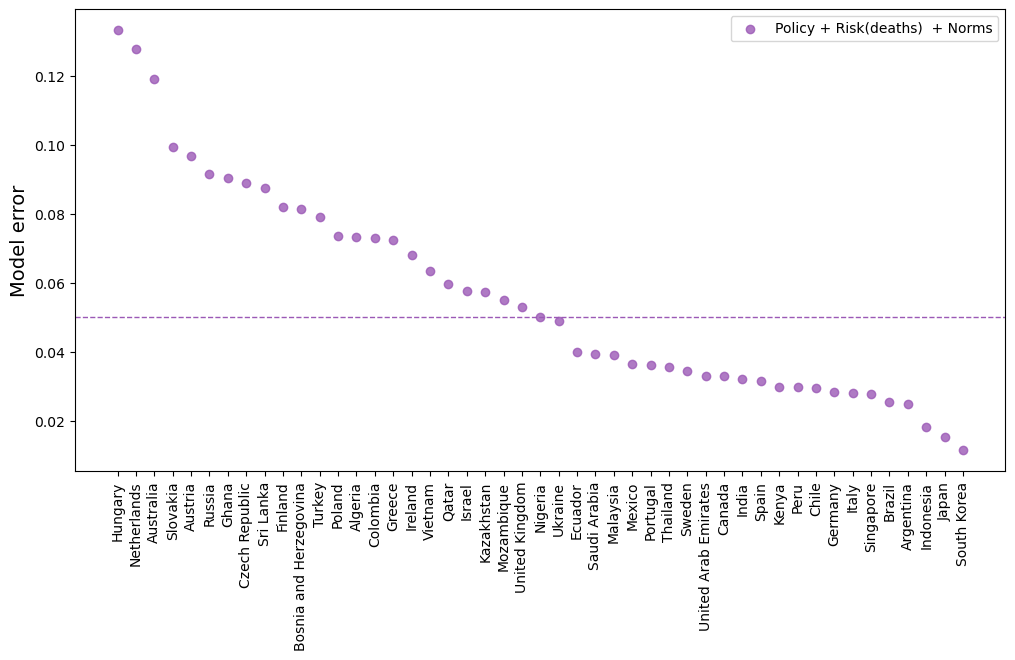

In [20]:
colors=['#1abc9c','#e67e22','#3498db','#9b59b6']


sorted_indices = np.argsort(cal_error)[::-1]

# Sorting countries and errors accordingly
sorted_countries = np.array(countries)[sorted_indices]
sorted_errors = np.array(cal_error)[sorted_indices]
#sorted_errors_A = np.array(cal_error_A)[sorted_indices]
#sorted_errors_C = np.array(cal_error_C)[sorted_indices]
#sorted_errors_E = np.array(cal_error_E)[sorted_indices]
#sorted_errors_cases=np.array(er_list_1)[sorted_indices]

sorted_countries_model=sorted_countries
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

#ax.scatter(sorted_countries, sorted_errors_A,label="Policy",c=colors[0],alpha=0.8)
#ax.scatter(sorted_countries, sorted_errors_C,label="Policy + Risk ",c=colors[1],alpha=0.8)
#ax.scatter(sorted_countries, sorted_errors_E,label="Policy + Norms",c=colors[2],alpha=0.8)
ax.scatter(sorted_countries, sorted_errors,label="Policy + Risk(deaths)  + Norms",c=colors[3],alpha=0.8)
#ax.scatter(sorted_countries, sorted_errors_cases,label="Policy + Risk(cases) + Norms",c=colors[2],alpha=0.8)
#ax.vlines(sorted_countries, ymin=0, ymax=sorted_errors, color='gray', linestyle='dotted', linewidth=0.7,alpha=0.5)
#ax.axhline(y=RMS_error_A,linestyle='--',linewidth=1,c=colors[0])
#ax.axhline(y=RMS_error_C,linestyle='--',linewidth=1,c=colors[1])
#ax.axhline(y=RMS_error_E,linestyle='--',linewidth=1,c=colors[2])
ax.axhline(y=np.median(cal_error),linestyle='--',linewidth=1,c=colors[3])
#ax.axhline(y=np.median(er_list_1),linestyle='--',linewidth=1,c=colors[2])

plt.xticks(rotation=90)
#plt.title("Error in predicted mask usage in calibration")
#plt.xlabel("Country",fontsize='14')
plt.ylabel("Model error",fontsize='14')
plt.legend()
#fig.savefig("Cal_error_cases.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)

In [21]:
#variation in mask usage over time

data_var=[]

for i in range(n_countries):
       
    dv,_ = country_var(country_params[i],i,mu,beta, step,model)
    data_var.append(dv)
    
    






Median error : 0.0503332998456217


Text(0, 0.5, 'Model error')

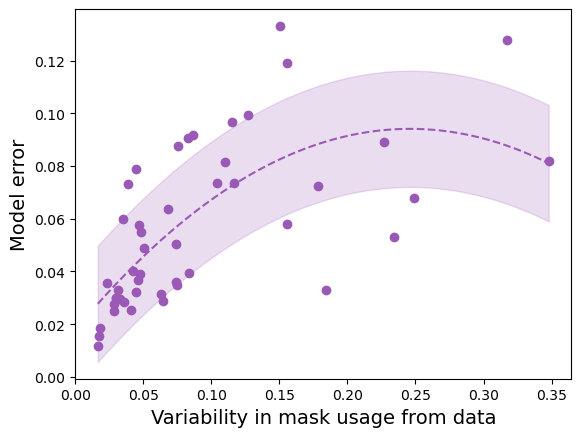

In [22]:
fig, ax = plt.subplots()

# Scatter plots
#ax.scatter(data_var_A, cal_error_A, label="Policy", c=colors[0])
#ax.scatter(data_var_C, cal_error_C, label="Policy and Risk perception", c=colors[1])
#ax.scatter(data_var_E, cal_error_E, label="Policy and Conformity", c=colors[2])
ax.scatter(data_var, cal_error, label="Policy, Risk  and Norm", c=colors[3])
x=data_var
y=cal_error
color=colors[3]
#label= 
# Quadratic fits with confidence bands
# for x, y, color, label in zip(
#     [data_var_A, data_var_C, data_var_E, data_var],
#     [cal_error_A, cal_error_C, cal_error_E, cal_error],
#     colors,
#     ['A', 'C', 'E', 'G']
# ):
coeffs = np.polyfit(x, y, 2)
x_fit = np.linspace(min(x), max(x), 200)
y_fit = np.polyval(coeffs, x_fit)

# Estimate spread as std of residuals
y_pred = np.polyval(coeffs, x)
residuals = y - y_pred
spread = np.std(residuals)

# Plot fit and spread
ax.plot(x_fit, y_fit, linestyle='--', color=color)
ax.fill_between(x_fit, y_fit - spread, y_fit + spread, color=color, alpha=0.2)

# Labels and legend
ax.set_xlabel("Variability in mask usage from data",fontsize='14')
ax.set_ylabel("Model error",fontsize='14')
#ax.legend()
#fig.savefig("Cal_error_vs_data_var.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)

# Temporal validation

In [60]:
param_min = country_params.min(axis=0)
param_max = country_params.max(axis=0)
param_norm = (country_params - param_min) / (param_max - param_min)
#print(param_norm)

# Uncertainity Quantification 

In [25]:
st = time.time()

B = 200  # number of bootstraps
block_len = 1  # example block size
theta_sd= np.zeros((n_countries,3))
boot_mean= np.zeros((n_countries,3))
period='all'
param_bounds=[(1e-5,20),(1e-5, 20),(1e-5,20)]
p = mp.Pool(processes=128)

y_obs_boot_list=np.zeros((n_countries,B,458))

for i in range(n_countries):


    residuals,y_pred_hat= country_residual(country_params[i],i,mu,beta, period,model)
    input_list=np.array([(residuals,block_len) for ii in range(B)],dtype=object)
    boot_residuals_list=p.starmap(block_bootstrap_residuals,input_list)
    for ii in range(B):
        y_obs_boot_list[i,ii]=y_pred_hat+boot_residuals_list[ii]


input_list= np.array([(mu,beta,i,y_obs_boot_list[i,ii],country_params[i],period,model,param_bounds) for i,ii in itertools.product(range(n_countries),range(B))], dtype=object)

theta_boots=p.starmap(optimize_country_params_boot,input_list)
theta_boots=np.array(theta_boots)
theta_boots.shape=(n_countries,B,3)
theta_sd=np.std(theta_boots,axis=1)
boot_mean=np.mean(theta_boots,axis=1)


p.close()
p.join()

et = time.time()

# get the execution time
elapsed_time = et - st
print('Uncertainity quantification time:', elapsed_time, 'seconds')
    
#%%



Uncertainity quantification time: 85.1758484840393 seconds


In [26]:
df['Risk_weight_sd']=theta_sd[:,0]
df['Norm_weight_sd']=theta_sd[:,1]
df['Policy_weight_sd']=theta_sd[:,2]
    

# Reorder columns to put 'Country' first (optional)
CP_df = df[['Country', 'Risk_weight', 'Norm_weight', 'Policy_weight','Risk_weight_sd','Norm_weight_sd','Policy_weight_sd']]
CP_df['Risk_weight_log']=np.log(CP_df['Risk_weight'])

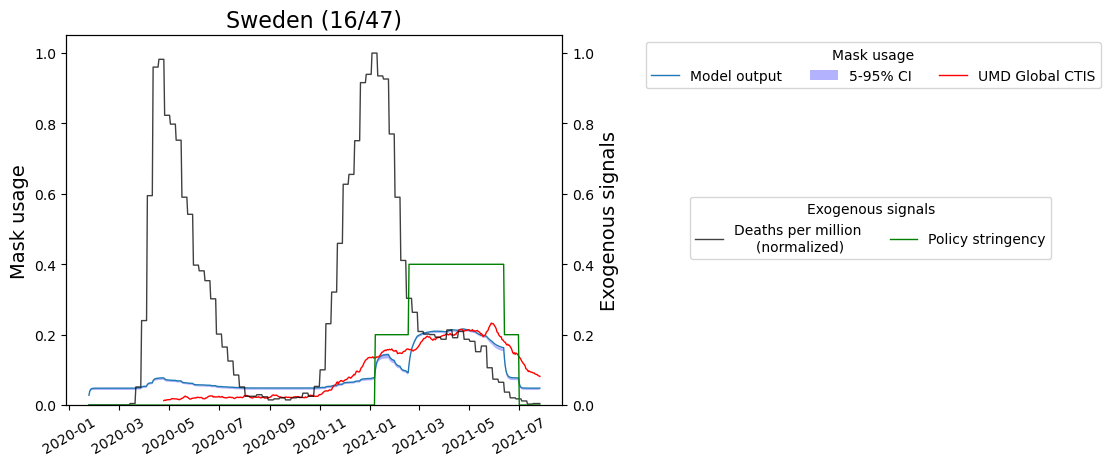

In [27]:
country='Sweden'
country_id=countries.index(country)

disease_incidence = np.array(new_death_df[new_death_df['country'] == country]['Deaths per mil'])
disease_incidence=(disease_incidence-min(disease_incidence))/(max(disease_incidence)-min(disease_incidence))
policy_mandates = np.array(policy_df[policy_df['Country'] == country]['H6M_Facial Coverings'])
policy_mandates=(policy_mandates-min(policy_mandates))/5
#mu=common_params_opt
mask_predicted=country_predicted(country,mu,beta,country_params[country_id],'G')
mask_umd_val = mask_df_val[mask_df_val['country'] == country]['pct']
mask_umd_cal = mask_df_cal[mask_df_cal['country'] == country]['pct']
mask_umd=mask_df[mask_df['country'] == country]['pct']
date_umd=mask_df[mask_df['country'] == country]['days_from_reference']

cal_date_umd=mask_df_cal[mask_df_cal['country'] == country]['days_from_reference']
val_date_umd=mask_df_val[mask_df_val['country'] == country]['days_from_reference']


#mask_wearing_observed_ug = yang_df[yang_df['country'] == country]['mask_percent']/100
#date_observed_ug=yang_df[yang_df['country'] == country]['days_from_reference']
fig,ax= plt.subplots()
ax.set_ylim(0,1.05)
ax.plot(date_range,mask_predicted,label='Model output', linewidth=1)

mask_predictions = np.zeros((B, len(mask_predicted)))

# Generate predictions for each bootstrap run
for i in range(B):
    mask_predictions[i, :] = country_predicted(country, mu,beta, theta_boots[country_id, i],'G')

lower_bound = np.percentile(mask_predictions, 5, axis=0)
upper_bound = np.percentile(mask_predictions, 95, axis=0)
ax.fill_between(date_range, lower_bound, upper_bound, color='b',edgecolor=None, alpha=0.3, label="5-95% CI")
    
plt.xticks(rotation=30)
ax2=ax.twinx()
#ax.plot(date_range[val_date_umd],mask_predicted[val_date_umd])

#ax.plot(date_range,mask_predicted,label='Prediction')
ax2.plot(date_range,disease_incidence,label='Deaths per million\n     (normalized) ',c='k',alpha=0.75, linewidth=1)
ax2.plot(date_range,policy_mandates,label='Policy stringency',c='green',alpha=1, linewidth=1)
ax.plot(date_range[date_umd],mask_umd,label='UMD Global CTIS',c='r', linewidth=1)
#ax.plot(date_range[cal_date_umd],mask_umd_cal,c='r', linewidth=0.75)
ax2.set_ylim(0,)
title=country+' ('+ str(47-list(sorted_countries_model).index(country))+'/47)'
ax.set_ylabel('Mask usage',fontsize=14)
ax2.set_ylabel('Exogenous signals',fontsize=14)
ax.set_title(title,fontsize=16)


#lgd=ax.legend(handles=handles,loc='lower center',fontsize="10", bbox_to_anchor=(1, 1),ncol=1, fancybox=True)
ax.legend(loc='upper right',fontsize="10", bbox_to_anchor=(2.1, 1),title='Mask usage',ncol=3)
ax2.legend(loc='center right',fontsize="10", bbox_to_anchor=(2, 0.48),title='Exogenous signals',ncol=2)
#fig.savefig(country+'.jpeg',dpi=400,bbox_inches='tight', pad_inches=0.1)

Text(0, 0.5, 'Risk weight (Z-score)')

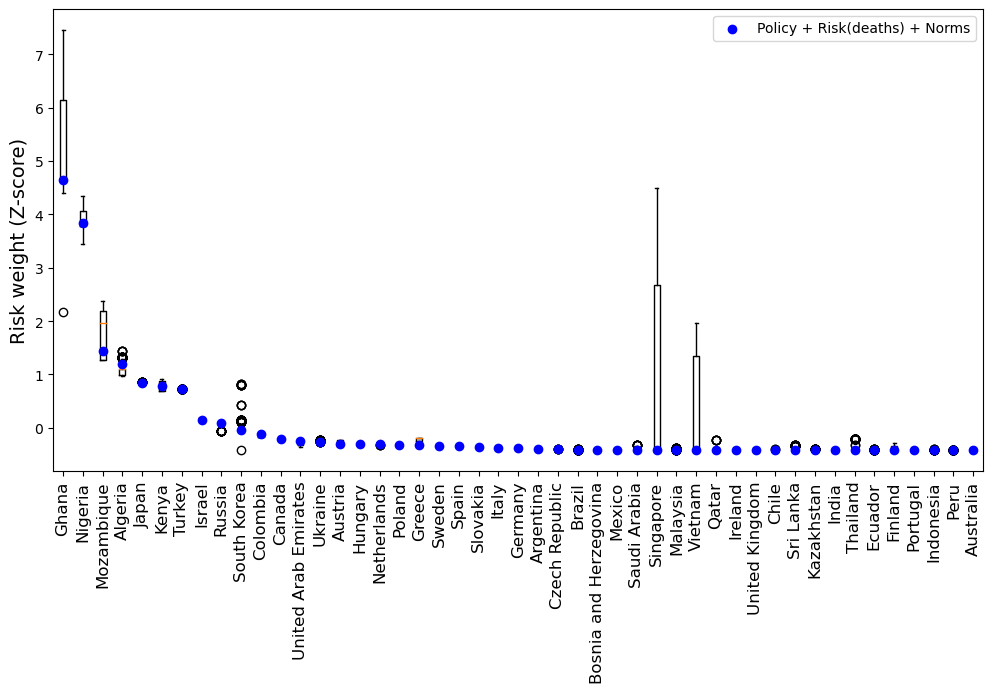

In [28]:
# 1. Get param_list and compute mean and std
#colors=['#3498db','#9b59b6']
param_list = country_params[:, 0]
mean_val = param_list.mean()
std_val = param_list.std()


# 2. Standardize param_list
param_list_std = (param_list - mean_val) / std_val


# 3. Standardize theta_boots using the same mean and std
theta_boots_vals = theta_boots[:, :, 0]  # shape: (n_countries, n_bootstraps)
theta_boots_std = (theta_boots_vals - mean_val) / std_val

# 4. Sort
sorted_indices = np.argsort(param_list_std)[::-1]
sorted_countries = np.array(countries)[sorted_indices]
sorted_param = param_list_std[sorted_indices]

sorted_boots = theta_boots_std[sorted_indices]

# 5. Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(list(sorted_boots), positions=range(len(countries)), widths=0.3)
ax.scatter(range(len(countries)), sorted_param, zorder=3,color='b',label='Policy + Risk(deaths) + Norms')
ax.legend()
plt.xticks(range(len(countries)), labels=sorted_countries, rotation=90, fontsize=12)
plt.ylabel("Risk weight (Z-score)", fontsize=14)
#fig.tight_layout()
#fig.savefig("Risk_standardized_cases.jpeg", dpi=400, bbox_inches='tight', pad_inches=0.1)

Text(0, 0.5, 'Norm weight (Z-score)')

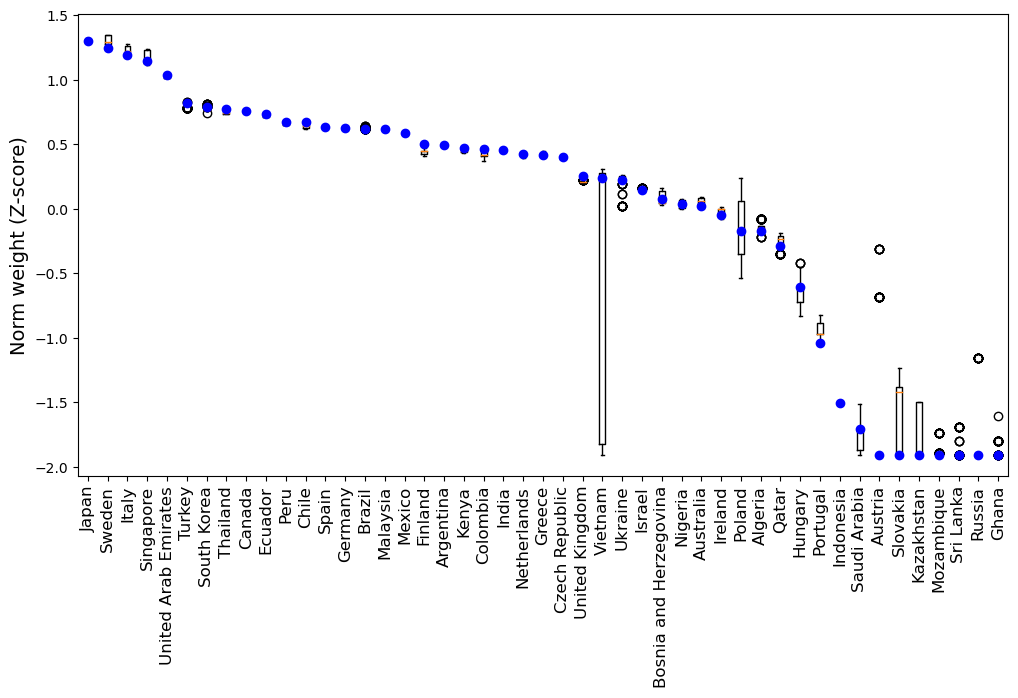

In [29]:
# 1. Get param_list and compute mean and std
param_list = country_params[:, 1]
mean_val = param_list.mean()
std_val = param_list.std()

# 2. Standardize param_list
param_list_std = (param_list - mean_val) / std_val

# 3. Standardize theta_boots using the same mean and std
theta_boots_vals = theta_boots[:, :, 1]  # shape: (n_countries, n_bootstraps)
theta_boots_std = (theta_boots_vals - mean_val) / std_val

# 4. Sort
sorted_indices = np.argsort(param_list_std)[::-1]
sorted_countries = np.array(countries)[sorted_indices]
sorted_param = param_list_std[sorted_indices]
sorted_boots = theta_boots_std[sorted_indices]

# 5. Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(list(sorted_boots), positions=range(len(countries)), widths=0.3)
ax.scatter(range(len(countries)), sorted_param, color='b', zorder=3)

plt.xticks(range(len(countries)), labels=sorted_countries, rotation=90, fontsize=12)
plt.ylabel("Norm weight (Z-score)", fontsize=14)
#fig.tight_layout()
#fig.savefig("conformity_standardized.jpeg", dpi=400, bbox_inches='tight', pad_inches=0.1)

Text(0, 0.5, 'Policy weight (Z-score)')

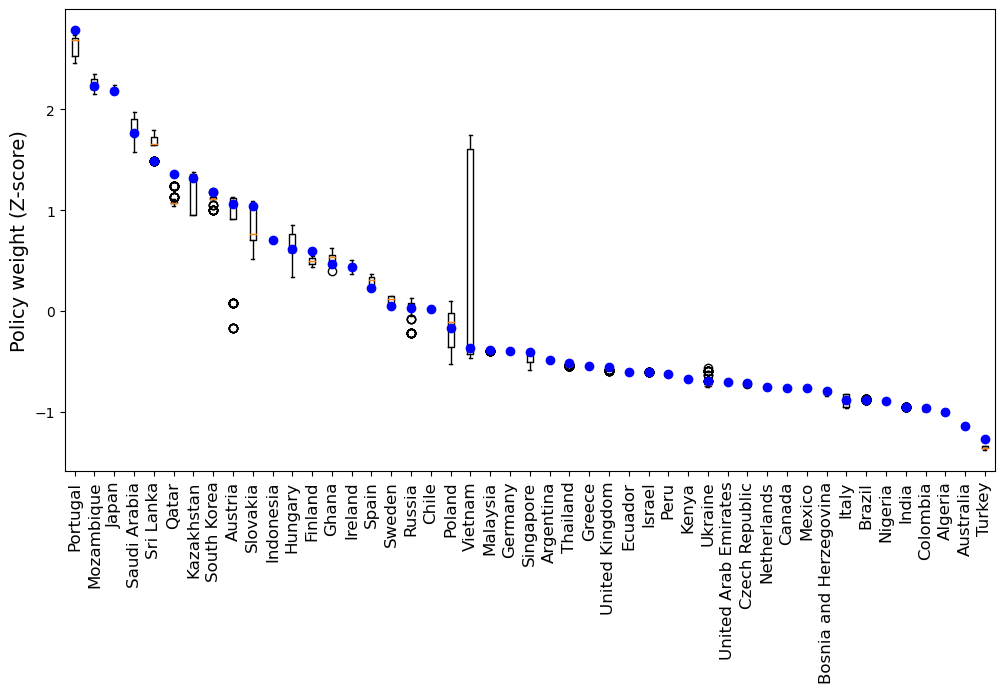

In [30]:
# 1. Get param_list and compute mean and std
param_list = country_params[:, 2]
mean_val = param_list.mean()
std_val = param_list.std()

# 2. Standardize param_list
param_list_std = (param_list - mean_val) / std_val

# 3. Standardize theta_boots using the same mean and std
theta_boots_vals = theta_boots[:, :, 2]  # shape: (n_countries, n_bootstraps)
theta_boots_std = (theta_boots_vals - mean_val) / std_val

# 4. Sort
sorted_indices = np.argsort(param_list_std)[::-1]
sorted_countries = np.array(countries)[sorted_indices]
sorted_param = param_list_std[sorted_indices]
sorted_boots = theta_boots_std[sorted_indices]

# 5. Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(list(sorted_boots), positions=range(len(countries)), widths=0.3)
ax.scatter(range(len(countries)), sorted_param, color='b', zorder=3)

plt.xticks(range(len(countries)), labels=sorted_countries, rotation=90, fontsize=12)
plt.ylabel("Policy weight (Z-score)", fontsize=14)
#fig.tight_layout()
#fig.savefig("policy_standardized.jpeg", dpi=400, bbox_inches='tight', pad_inches=0.1)

# Checking association of decision weights with known Social, economic and cultural indicators

In [31]:
file_name='Data/control_variables.pickle'
CV_df=pd.read_pickle(file_name)


file_name = 'Data/collectivism.pickle'
coll_df=pd.read_pickle(file_name)


# file_name='Data/trust.pickle'
# trust_df=pd.read_pickle(file_name)

    
file_path = 'Data/Tightness_Scores.xlsx'
conformity_df = pd.read_excel(file_path)


dataframes = [CP_df, conformity_df,coll_df, CV_df]
df = combine_country_dataframes(dataframes)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#df = df.rename(columns={'Score': 'Trust'})

df = df[df['Country'].isin(countries)]
df["Population_density_log"] =   np.log(df['Population_density'])
df["GDP_per_capita_log"] =   np.log(df["GDP"])
#df["conf_pop"]=df["Norm_weight"]/df["Population_density"]

print(df)   


                   Country  Risk_weight  Norm_weight  Policy_weight  \
0                   Israel     0.698845     9.450182       0.502667   
1                   Mexico     0.000130    11.519302       0.421524   
2                   Greece     0.107237    10.718496       0.536994   
3                   Canada     0.252588    12.305444       0.423719   
4                  Ukraine     0.194380     9.837224       0.456306   
5                Australia     0.000010     8.891043       0.225758   
6                   Turkey     1.421117    12.574552       0.160340   
7   Bosnia and Herzegovina     0.003873     9.130954       0.407760   
8                 Portugal     0.000010     3.992925       2.265256   
9                Indonesia     0.000010     1.843055       1.183967   
10                 Algeria     2.011798     7.993082       0.300522   
11                  Poland     0.121164     8.013728       0.729213   
12                   Ghana     6.282326     0.000010       1.063049   
13    

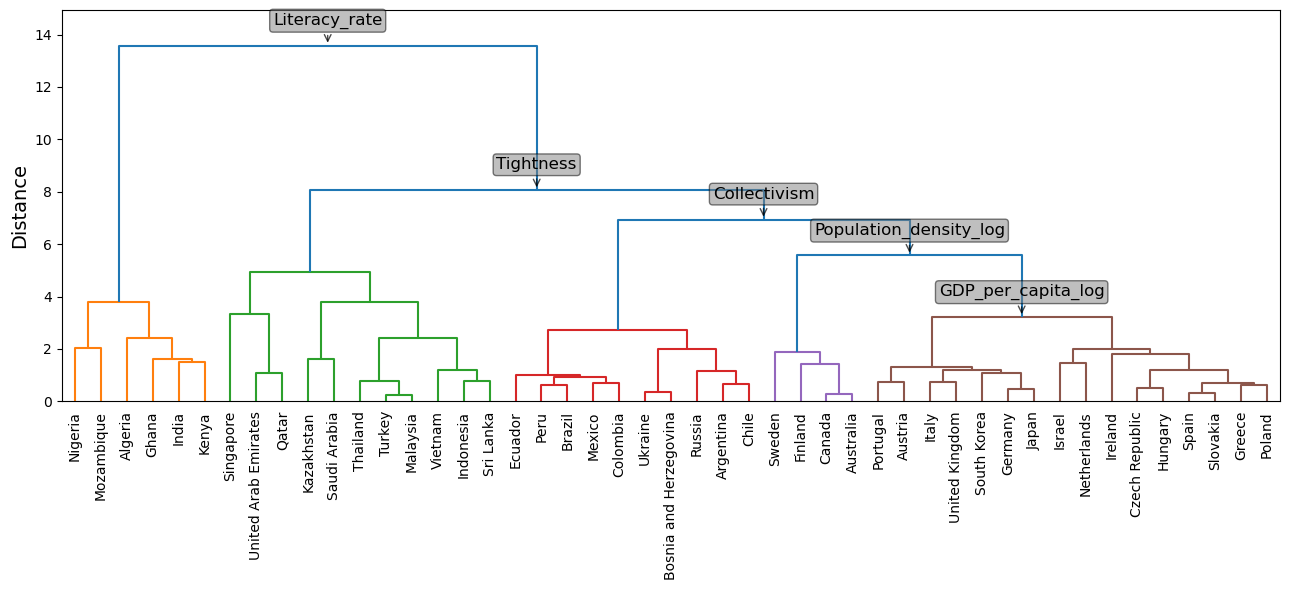

In [32]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# from sklearn.preprocessing import StandardScaler

df1 = df[['Country','Tightness','Collectivism',"GDP_per_capita_log","Literacy_rate","Population_density_log"]].dropna()
variables = ['Tightness','Collectivism',"GDP_per_capita_log","Literacy_rate","Population_density_log"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df1[variables])

linked = linkage(X_scaled, method='ward')

fig, ax = plt.subplots(figsize=(13, 6))
ddata = dendrogram(
    linked, 
    labels=df1['Country'].values, 
    leaf_rotation=90, 
    leaf_font_size=10, 
    color_threshold=0.4 * max(linked[:, 2]),
    ax=ax
)

# Annotate the main bifurcations with "driver" variables
def get_cluster_indices(n_samples, node):
    """Recursively extract the sample indices from a linkage node."""
    if node < n_samples:
        return [node]
    else:
        left, right = int(linked[node - n_samples, 0]), int(linked[node - n_samples, 1])
        return get_cluster_indices(n_samples, left) + get_cluster_indices(n_samples, right)

n_samples = X_scaled.shape[0]
top_n = 5  # How many top splits to annotate

# Get the top splits by distance (biggest splits)
top_splits = np.argsort(linked[:, 2])[-top_n:]

for split in top_splits:
    left_idx = int(linked[split, 0])
    right_idx = int(linked[split, 1])
    left_inds = get_cluster_indices(n_samples, left_idx)
    right_inds = get_cluster_indices(n_samples, right_idx)
    
    left_mean = X_scaled[left_inds].mean(axis=0)
    right_mean = X_scaled[right_inds].mean(axis=0)
    diff = np.abs(left_mean - right_mean)
    driver_var = variables[np.argmax(diff)]

    # Find coordinates for annotation
    x = 0.5 * (ddata['icoord'][split][1] + ddata['icoord'][split][2])
    y = ddata['dcoord'][split][1]
    ax.annotate(
        driver_var, 
        xy=(x, y), 
        xytext=(x, y+0.8), 
        arrowprops=dict(facecolor='black', arrowstyle='->', lw=1, alpha=0.7),
        ha='center', 
        fontsize=12, 
        bbox=dict(boxstyle='round,pad=0.2', fc='grey', alpha=0.5,ec='black')
    )

ax.set_ylabel('Distance', fontsize=14)
ax.set_ylim(0, max(linked[:, 2]) * 1.1)
plt.tight_layout()
#plt.savefig("Country_HC_SEC_annotated.png", dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()


In [33]:
#print(linked)

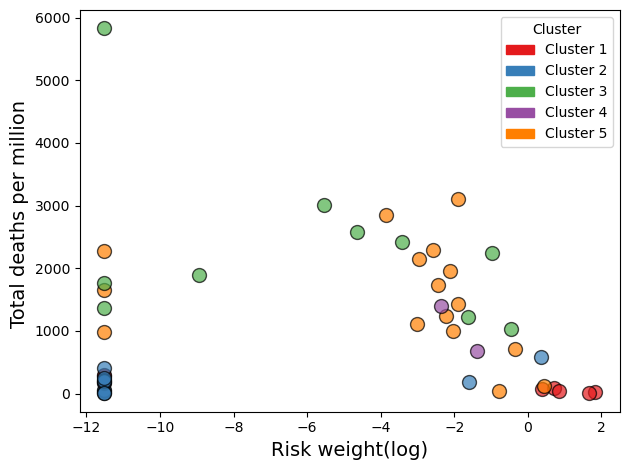

In [34]:
from scipy.cluster.hierarchy import fcluster
colors_region = [
    "#E41A1C",  # red
    "#377EB8",  # blue
    "#4DAF4A",  # green
    "#984EA3",  # purple
    "#FF7F00",  # orange
    "#A65628",  # brown
    "#F781BF",  # pink
    "#999999",  # grey
    "#66C2A5",  # teal
    "#FFD92F"   # yellow
]
clusters_list = fcluster(linked, t=5, criterion='maxclust')
#print(clusters)
df['cluster'] = clusters_list
#scaled_df['cluster'] = clusters
#print(df[[ 'cluster']].head())
scaled_df = pd.DataFrame(X_scaled, columns=variables)
scaled_df['Country'] = df1['Country'].values
scaled_df['cluster'] = np.array(clusters_list)
df['total_deaths'] = np.nan

total_deaths_list=[]



fig, ax = plt.subplots()
for country in countries:
    disease_incidence = np.array(new_death_df[new_death_df['country'] == country]['Deaths per mil'])
    #find first non-zero value and take the mean from there on      
    
    #disease_incidence = disease_incidence[disease_incidence > 0] 
    #print(len(disease_incidence))
    
    avg_deaths = np.sum(disease_incidence) 
    df.loc[df['Country'] == country, 'total_deaths'] = avg_deaths
    total_deaths_list.append(avg_deaths)
    #total_deaths = np.array(new_death_df['Deaths per mil'])
    #total_deaths = total_deaths[total_deaths > 0]
   # avg_deaths= total_deaths[countries.index(country)]
    # Use the correct column access for Population_density_log
    pop_density = df[df['Country'] == country]['Population_density'].values[0]
    # Normalize average deaths by population density    
    avg_deaths_norm = avg_deaths / (pop_density)**1
  
    # Get cluster number for the country (subtract 1 for zero-based index)
    cluster_num = int(scaled_df[scaled_df['Country'] == country]['cluster'].values[0]) - 1
    color = colors_region[cluster_num]
    #print(df['Risk_log'].iloc[i])
    ax.scatter(df[df['Country'] == country]['Risk_weight_log'].values[0], avg_deaths , alpha=0.7, edgecolors='black', c=color, s=100)
#add legend for clusters
handles, labels = ax.get_legend_handles_labels()
patches = [mpatches.Patch(color=colors_region[i], label=f'Cluster {i+1}') for i in range(5)]
handles.extend(patches)
ax.legend(handles=handles, loc='upper right', title='Cluster', fontsize="10", ncol=1, fancybox=True)
ax.set_xlabel('Risk weight(log)', fontsize=14)
ax.set_ylabel('Total deaths per million ', fontsize=14)
#plt.title('Average Deaths vs Risk perception by Country', fontsize=16)
plt.tight_layout()
#plt.savefig("Average_deaths_vs_risk.png", dpi=400, bbox_inches='tight', pad_inches=0.1)


In [35]:
# Select relevant columns and drop rows with missing values
norm_df = df[['Risk_weight', 'Policy_weight', 'Norm_weight', 'total_deaths']].dropna()

# Standardize the columns (z-score normalization)
for col in ['Risk_weight', 'Policy_weight', 'Norm_weight', 'total_deaths']:
    norm_df[col] = (norm_df[col] - norm_df[col].mean()) / norm_df[col].std()

# Define features and target variable
features = ['Risk_weight', 'Policy_weight', 'Norm_weight']
X = norm_df[features]
X = sm.add_constant(X)  # Add intercept term
y = norm_df['total_deaths']

# Fit OLS regression model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_deaths   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     2.325
Date:                Wed, 20 Aug 2025   Prob (F-statistic):             0.0882
Time:                        13:56:45   Log-Likelihood:                -62.651
No. Observations:                  47   AIC:                             133.3
Df Residuals:                      43   BIC:                             140.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.327e-17      0.140   5.95e-16

In [46]:
from scipy.stats import ttest_ind

alpha = 0.05

clusters = scaled_df['cluster'].unique()
print(clusters)
variables = ['Tightness','Collectivism',"GDP_per_capita_log","Literacy_rate","Population_density_log"]
t_stats_var = pd.DataFrame(index=clusters, columns=variables)
desired_order = [1, 2, 3, 4,5]
t_stats_var = t_stats_var.loc[desired_order]
p_vals_var = pd.DataFrame(index=clusters, columns=variables,dtype=float)
p_vals_var = p_vals_var.loc[desired_order]
for cluster in clusters:
    group = scaled_df[scaled_df['cluster'] == cluster]
    rest = scaled_df[scaled_df['cluster'] != cluster]
    
    for var in variables:
        t_val, p_val = ttest_ind(group[var], rest[var], equal_var=False)
        t_stats_var.loc[cluster, var] = t_val  # Or use p_val if you prefer
        p_vals_var.loc[cluster, var] = p_val
        
t_stats_var = t_stats_var.astype(float)
sig_mask = p_vals_var.astype(float) > alpha


[5 3 4 2 1]


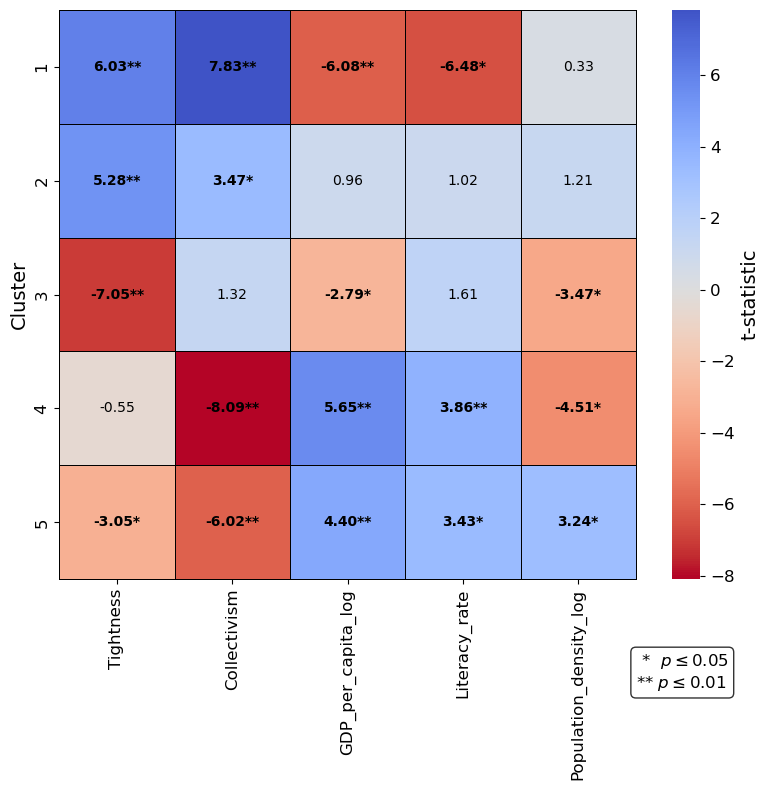

In [ ]:
# Create annotation matrix with t-stats and significance stars
annot = t_stats_var.copy().astype(str)

for i in t_stats_var.index:
    for j in t_stats_var.columns:
        t_val = t_stats_var.loc[i, j]
        p_val = p_vals_var.loc[i, j]

        # Decide star level based on p-value
        if p_val <= 0.001:
            stars = '**'
        elif p_val <= 0.05:
            stars = '*'
        else:
            stars = ''

        # Format annotation
        annot.loc[i, j] = f"{t_val:.2f}{stars}"

# Plot heatmap with mask applied
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    t_stats_var, 
    annot=annot,
    #mask=sig_mask,
    fmt="",
    center=0, cmap='coolwarm_r', annot_kws={"color": "black"},
    cbar_kws={'label': 't-statistic'}, linewidths=0.5, linecolor='black', clip_on=False
)

sig_flat = (p_vals_var.values <= 0.05).ravel(order='C')
for txt, sig in zip(ax.texts, sig_flat):
    if sig:
        txt.set_fontweight('bold')

legend_x, legend_y = 1, -0.2  # adjust position relative to plot
legend_text = (
    
    r" *  $p \leq 0.05$" + "\n" +
    r"** $p \leq 0.01$"
)
ax.text(
    legend_x, legend_y, legend_text,
    transform=ax.transAxes, fontsize=12,
    verticalalignment='bottom',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)
# Adjust colorbar and labels
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('t-statistic', fontsize=14)
ax.tick_params(labelsize=12)
plt.ylabel('Cluster', fontsize=14)
plt.tight_layout()
#plt.savefig("SEC_T_stat.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)
plt.show()



In [48]:
params_df = df[['Country', 'Norm_weight', 'Policy_weight', 'Risk_weight']].dropna()
parameters = ['Norm_weight', 'Policy_weight', 'Risk_weight']
merged = pd.merge(params_df, df1, on='Country')
merged['cluster'] = np.array(clusters_list)

#print(merged)
param_scaled = scaler.fit_transform(merged[parameters])

param_scaled_df = pd.DataFrame(param_scaled, columns=parameters)
param_scaled_df['cluster'] = merged['cluster'].values
# cluster_param_summary = param_scaled_df.groupby('cluster')[parameters].mean()
# plt.figure(figsize=(8, 5))
# sns.heatmap(cluster_param_summary, annot=True,fmt=".2f", cmap='vlag_r', center=0,annot_kws={"size": 12, "color": "black"})
# plt.title('Cluster Profiles (Standardized Calibrated Parameters)')
# plt.ylabel('Cluster')
# plt.tight_layout()
# plt.show()
#print(param_scaled_df)

In [49]:


clusters = param_scaled_df['cluster'].unique()

t_stats = pd.DataFrame(index=clusters, columns=parameters)
desired_order = [1, 2, 3, 4,5]
t_stats = t_stats.loc[desired_order]
p_vals = pd.DataFrame(index=clusters, columns=parameters, dtype=float)
p_vals = p_vals.loc[desired_order]

for cluster in clusters:
    group = param_scaled_df[param_scaled_df['cluster'] == cluster]
    rest = param_scaled_df[param_scaled_df['cluster'] != cluster]
    
    for var in parameters:
        t_val, p_val = ttest_ind(group[var], rest[var], equal_var=False)
        t_stats.loc[cluster, var] = t_val  # Or use p_val if you prefer
        p_vals.loc[cluster, var] = p_val
sig_mask = p_vals.astype(float) > alpha        
t_stats = t_stats.astype(float)


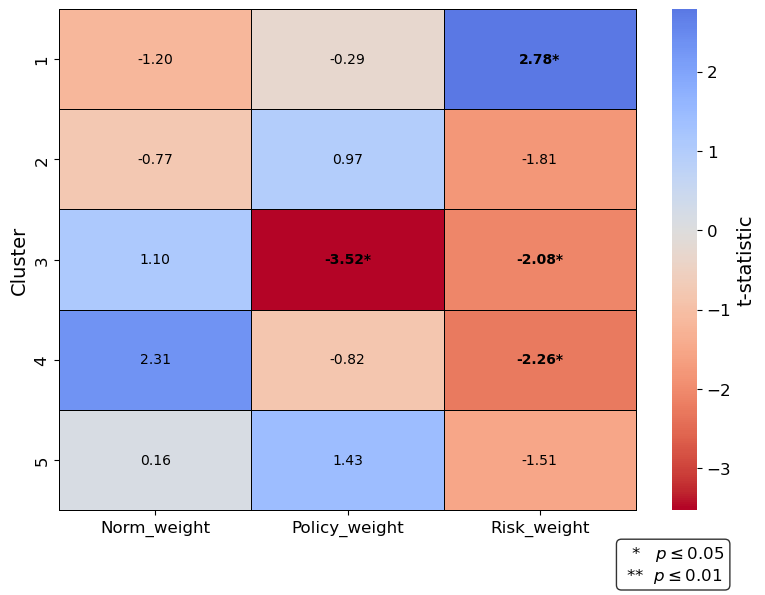

In [ ]:
annot = t_stats.copy().astype(str)
for i in t_stats.index:
    for j in t_stats.columns:
        t_val = t_stats.loc[i, j]
        p_val = p_vals.loc[i, j]
        if p_val <= 0.001:
            stars = '**'
        elif p_val <= 0.05:
            stars = '*'
        #elif p_val <= 0.1:
        #    stars = '*'
        else:
            stars = ''
        annot.loc[i, j] = f"{t_val:.2f}{stars}"

# ---- Plot heatmap ----
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    t_stats,  annot=annot, fmt="", 
    center=0, cmap='coolwarm_r', annot_kws={"color": "black"},
    linewidths=0.5, linecolor='black', clip_on=False
)

sig_flat = (p_vals.values <= 0.05).ravel(order='C')
for txt, sig in zip(ax.texts, sig_flat):
    if sig:
        txt.set_fontweight('bold')
        
legend_x, legend_y = 0.975, -0.15  # adjust position relative to plot
legend_text = (
    r"  *   $p \leq 0.05$" + "\n" +   r" **  $p \leq 0.01$" )
ax.text(
    legend_x, legend_y, legend_text,
    transform=ax.transAxes, fontsize=12,
    verticalalignment='bottom',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('t-statistic', fontsize=14)
ax.tick_params(labelsize=12)
plt.ylabel('Cluster', fontsize=14)
plt.tight_layout()
#plt.savefig("param_T_stat.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)

Edges (Variable -- Parameter) with co-significance counts and product of t-stats:
Tightness -- Policy_weight: weight = 1, product = 1.00
Tightness -- Risk_weight: weight = 2, product = 1.00
Collectivism -- Risk_weight: weight = 2, product = 1.00
GDP_per_capita_log -- Policy_weight: weight = 1, product = 1.00
GDP_per_capita_log -- Risk_weight: weight = 3, product = -1.00
Literacy_rate -- Risk_weight: weight = 2, product = -1.00
Population_density_log -- Policy_weight: weight = 1, product = 1.00
Population_density_log -- Risk_weight: weight = 2, product = 1.00


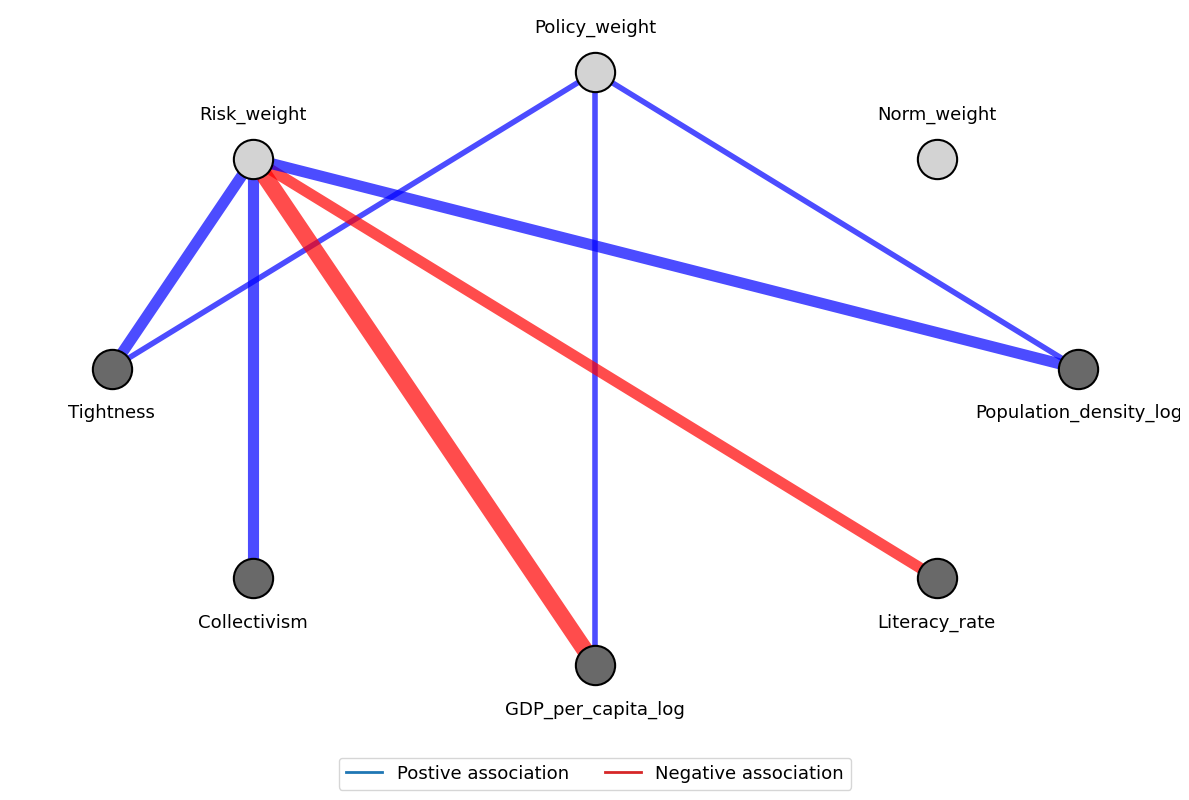

In [41]:
import matplotlib as mpl


# Define significance threshold


# Dictionaries to store edge attributes
edge_weights = {}   # number of clusters where both are significant
edge_products = {}  # sum of products of t-stats for those clusters

# Loop over each variable and each parameter
for var in variables:
    for param in parameters:
        common_sig = 0
        product_sum = 0
        for cluster in p_vals.index:  # Loop through clusters
            # Check significance for the variable (p_vals_var) and parameter (p_vals)
            if (p_vals_var.loc[cluster, var] < alpha) and (p_vals.loc[cluster, param] < alpha):# and t_stats_var.loc[cluster, var] * t_stats.loc[cluster, param]>0:
                common_sig += 1
                # Multiply the corresponding t-statistics from each analysis
                product_sum += t_stats_var.loc[cluster, var] * t_stats.loc[cluster, param]
        if common_sig > 0:
            edge_weights[(var, param)] = common_sig
            edge_products[(var, param)] = product_sum/abs(product_sum)  # Average product of t-stats across significant clusters

# Build the bipartite graph
B = nx.Graph()

# Add nodes with a bipartite attribute: 0 for variables, 1 for parameters.
B.add_nodes_from(variables, bipartite=0, label='variable')
B.add_nodes_from(parameters, bipartite=1, label='parameter')

# Add edges with both weight and product attributes
for (var, param), weight in edge_weights.items():
    prod = edge_products[(var, param)]
    B.add_edge(var, param, weight=weight, product=prod)

# (Optional) Print the edge list with attributes
print("Edges (Variable -- Parameter) with co-significance counts and product of t-stats:")
for u, v, data in B.edges(data=True):
    print(f"{u} -- {v}: weight = {data['weight']}, product = {data['product']:.2f}")

# Prepare for visualization:
# Create a list of product values from the edge attributes.
edge_product_values = [data['product']/3 for u, v, data in B.edges(data=True)]
edge_widths = [edge_weights[(u, v)]*4 for u, v in B.edges()]
# Set up colormap normalization based on min and max of product values
cmap = plt.cm.coolwarm_r
norm = mpl.colors.Normalize(vmin=min(edge_product_values), vmax=max(edge_product_values))

# Map each edge's product to a color
colors=['blue','red']
#edge_colors = [cmap(norm(val)) for val in edge_product_values]\
edge_colors = [colors[int(val<0)] for val in edge_product_values]

# Get a bipartite layout with variables on one side.
#pos = nx.bipartite_layout(B, variables)
#pos = nx.spring_layout(B)
pos = nx.shell_layout(B)

# Create a figure and axis for the graph.
fig, ax = plt.subplots(figsize=(12, 8))

# Draw the graph on the given axis.
nx.draw_networkx_nodes(B, pos, nodelist=variables, node_color='dimgrey', edgecolors='black',
                       linewidths=1.5, node_size=800, label='Variables', ax=ax)
nx.draw_networkx_nodes(B, pos, nodelist=parameters, node_color='lightgrey', edgecolors='black',
                       linewidths=1.5, node_size=800, label='Parameters', ax=ax)
nx.draw_networkx_edges(B, pos, edge_color=edge_colors, width=edge_widths, ax=ax,alpha=0.7)

# Shift the label positions upward.
offset = 0.15  # adjust this offset as necessary

label_pos = {node: (x, y + offset if node in parameters else y - offset)
             for node, (x, y) in pos.items()}

nx.draw_networkx_labels(B, label_pos, font_size=13, ax=ax)


# Set up the ScalarMappable and add a colorbar using the axis.
sm1 = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm1.set_array([])

from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0], [0], color='tab:blue', lw=2, label='Postive association'),
    Line2D([0], [0], color='tab:red',  lw=2, label='Negative association')
]
ax.legend(handles=legend_elems, loc='lower center', bbox_to_anchor=(0.5, -0.1),ncol=2, fancybox=True,fontsize=13)

#plt.subplots_adjust( right=0.5) 
#ax.set_title("Bipartite Network: Variables vs. Parameters (Co-significance & t-stats Product)")
ax.axis('off')
plt.tight_layout()
#cbar = fig.colorbar(sm1, ax=ax, label='Sum(Product of t-stats)')
plt.show()
#fig.savefig("bipartite.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)
#print(pos)

## Temporal validation


In [42]:
start_time = datetime.datetime.now()
# Print the start time
print("Simulation started at:", start_time.strftime("%H:%M"))
st = time.time()

p = mp.Pool(processes=128)



period='cal'


input_list= np.array([(mu,beta,ii,period,model,param_bounds) for ii in range(len(countries))], dtype=object)

country_params_temp=p.starmap(optimize_country_params,input_list)
country_params_temp=np.array(country_params_temp)

print('Calibration time:', elapsed_time, 'seconds')
country_params_temp.shape=(n_countries,3)





et = time.time()
elapsed_time = et - st


p.close()
p.join()


Simulation started at: 13:57
Calibration time: 85.1758484840393 seconds


In [43]:
cal_error=[]
val_error=[]
for i in range(n_countries):
    error = country_error(country_params_temp[i],i,mu,beta, 'cal',model)
    cal_error.append(error)
    error = country_error(country_params_temp[i],i,mu,beta, 'val',model)
    val_error.append(error)
    


/scratch-local/dmittal.14173709/ipykernel_179914/1042771027.py:36: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


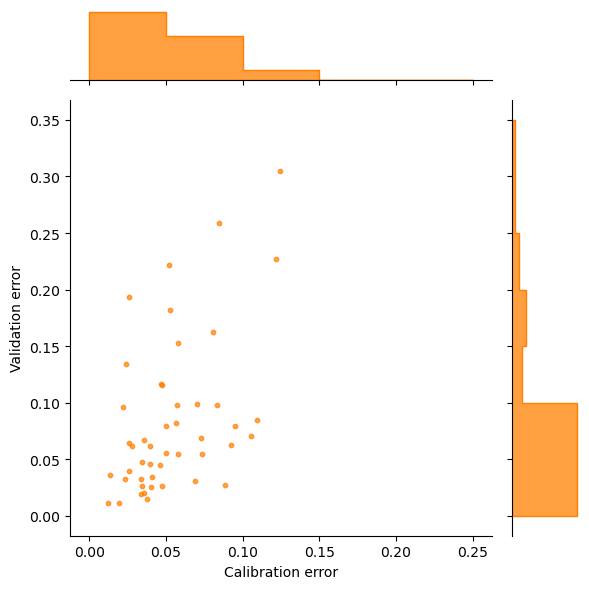

In [44]:
#model_list = ['A', 'C', 'E','G']

model_names=['Policy + Risk + Norm']
model_name='Policy + Risk + Norm'
g = sns.JointGrid()

g.ax_joint.scatter(cal_error, val_error, label=model_name, color=color, alpha=0.7, s=10)

# Add the marginal distributions

sns.histplot(x=cal_error, ax=g.ax_marg_x,stat='density', element='step', common_norm=False, bins=np.linspace(0,0.25,6),color=color)

sns.histplot( y=val_error, ax=g.ax_marg_y,stat='density', element='step', common_norm=False, bins=np.linspace(0,0.35,8),color=color)


#df['model_name']=['Policy','Policy + Risk perception','Policy + Conformity','Policy + Risk perception + Conformity']

# # Plot jointplot with contour (KDE)
# g = sns.jointplot(
#     data=df,
#     x='cal_error', y='val_error'
#     #hue='model',
#     #palette=colors
   
# )

#g.ax_joint.set_xlim(0, df['cal_error'].max() + 0.05)
#g.ax_joint.set_ylim(0, df['val_error'].max() + 0.05)
# g.ax_joint.axhline(y=0.05, c='k', linestyle='--', linewidth=0.5)
# g.ax_joint.axhline(y=0.1, c='k', linestyle='--', linewidth=0.5)
# g.ax_joint.axvline(x=0.05, c='k', linestyle='--', linewidth=0.5)
# g.ax_joint.axvline(x=0.1, c='k', linestyle='--', linewidth=0.5)

g.ax_joint.set_xlabel('Calibration error')
g.ax_joint.set_ylabel('Validation error')
g.fig.tight_layout()
plt.show()
#g.fig.savefig("Cal_val_1.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)

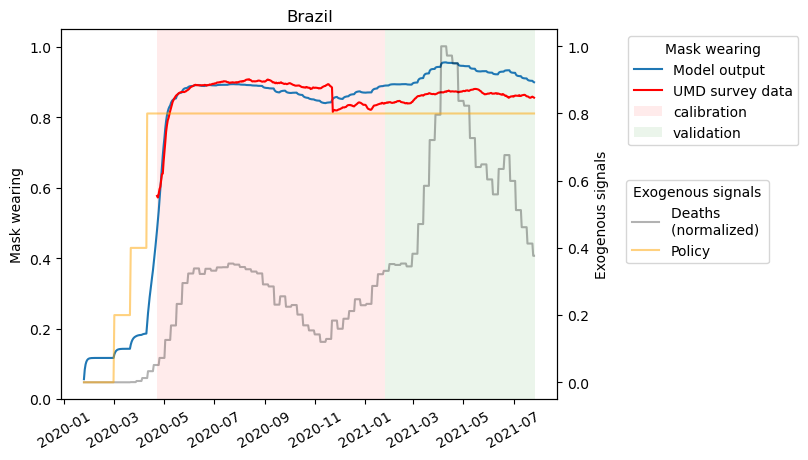

In [45]:
country='Brazil'



country_id=countries.index(country)

disease_incidence = np.array(new_death_df[new_death_df['country'] == country]['Deaths per mil'])
disease_incidence=(disease_incidence-min(disease_incidence))/(max(disease_incidence)-min(disease_incidence))
policy_mandates = np.array(policy_df[policy_df['Country'] == country]['H6M_Facial Coverings'])
policy_mandates=(policy_mandates-min(policy_mandates))/5

mask_predicted=country_predicted(country,mu,beta,country_params_temp[country_id],'G')
mask_umd_val = mask_df_val[mask_df_val['country'] == country]['pct']
mask_umd_cal = mask_df_cal[mask_df_cal['country'] == country]['pct']

cal_date_umd=mask_df_cal[mask_df_cal['country'] == country]['days_from_reference']
val_date_umd=mask_df_val[mask_df_val['country'] == country]['days_from_reference']


fig,ax= plt.subplots()
ax.set_ylim(0,1.05)
ax.plot(date_range,mask_predicted,label='Model output')
plt.xticks(rotation=30)
ax2=ax.twinx()

ax2.plot(date_range,disease_incidence,label='Deaths \n(normalized) ',c='k',alpha=0.3)
ax2.plot(date_range,policy_mandates,label='Policy',c='orange',alpha=0.5)
ax.plot(date_range[val_date_umd],mask_umd_val,label='UMD survey data',c='r')
ax.plot(date_range[cal_date_umd],mask_umd_cal,c='r')
ax.bar(date_range[cal_date_umd][0],bottom=0.0, width=len(cal_date_umd), color='r', edgecolor=None, align='edge',height=1.05,alpha=0.08,label='calibration')
ax.bar(date_range[val_date_umd][0],bottom=0.0, width=len(val_date_umd), color='g', edgecolor=None, align='edge',height=1.05,alpha=0.08,label='validation')



ax.set_ylabel('Mask wearing')
ax2.set_ylabel('Exogenous signals')
ax.set_title(country)

#handles, labels = ax.get_legend_handles_labels()
#handles.extend([line1,line2])
#lgd=ax.legend(handles=handles,loc='lower center',fontsize="10", bbox_to_anchor=(1, 1),ncol=1, fancybox=True)
ax.legend(loc='upper right',fontsize="10", bbox_to_anchor=(1.5, 1),title='Mask wearing')
ax2.legend(loc='center right',fontsize="10", bbox_to_anchor=(1.44, 0.48),title='Exogenous signals')